In [3]:
import gc
import pandas as pd
# 用户行为，使用format1进行加载
# 加载全量样本

user_log = pd.read_csv('../data/data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('../data/data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('../data/data_format1/train_format1.csv')
submission = pd.read_csv('../data/data_format1/test_format1.csv')

# 加载小样本
# user_log = pd.read_csv('./data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
# user_info = pd.read_csv('./data_format1_small/sample_user_info.csv')
# train_data1 = pd.read_csv('./data_format1_small/train.csv')
# submission = pd.read_csv('./data_format1_small/test.csv')
train_data = pd.read_csv('./data_format2/train_format2.csv')


In [4]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
print(matrix)

        user_id  merchant_id  label origin  prob
0         34176         3906    0.0  train   NaN
1         34176          121    0.0  train   NaN
2         34176         4356    1.0  train   NaN
3         34176         2217    0.0  train   NaN
4        230784         4818    0.0  train   NaN
...         ...          ...    ...    ...   ...
522336   228479         3111    NaN   test   NaN
522337    97919         2341    NaN   test   NaN
522338    97919         3971    NaN   test   NaN
522339    32639         3536    NaN   test   NaN
522340    32639         3319    NaN   test   NaN

[522341 rows x 5 columns]


In [5]:
matrix.drop(['prob'], axis=1, inplace=True)
# 连接user_info表，通过user_id关联
matrix = matrix.merge(user_info, on='user_id', how='left')
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d')
# 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del user_info, train_data1
gc.collect()
print(matrix)

        user_id  merchant_id label origin  age_range  gender
0         34176         3906   0.0  train          6       0
1         34176          121   0.0  train          6       0
2         34176         4356   1.0  train          6       0
3         34176         2217   0.0  train          6       0
4        230784         4818   0.0  train          0       0
...         ...          ...   ...    ...        ...     ...
522336   228479         3111   nan   test          6       0
522337    97919         2341   nan   test          8       1
522338    97919         3971   nan   test          8       1
522339    32639         3536   nan   test          0       0
522340    32639         3319   nan   test          0       0

[522341 rows x 6 columns]


In [27]:
# User特征处理
groups = user_log.groupby(['user_id'])
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
# 使用agg 基于列的聚合操作，统计唯一值的个数 item_id, cat_id, merchant_id, brand_id
#temp = groups['item_id', 'cat_id', 'merchant_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'u2', 'cat_id':'u3', 'merchant_id':'u4', 'brand_id':'u5'})
# 对于每个user_id 不重复的item_id的数量 => u2
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 对于每个user_id 不重复的cat_id的数量 => u3
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

# 时间间隔特征 u6 按照小时
# 对于每个user_id 计算time_stamp的最小时间 => F_time, 最大时间max => L_time
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')
print(matrix)

        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4   u5   u6      u7   u8    u

In [28]:
# 商家特征处理
groups = user_log.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'seller_item_attention', 'cat_id':'m4', 'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
#print(matrix)

<ipython-input-28-313c2df56631>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'seller_item_attention', 'cat_id':'m4', 'brand_id':'m5'})


In [29]:
# 按照user_id, merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'}) #统计行为个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})#统计不同action_type唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['first', 'last'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left') #统计时间间隔
#print(matrix)

<ipython-input-29-7bfaa8c0ed53>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数


In [30]:
#用户购买点击比
matrix['user_click2buy'] = matrix['u9']/matrix['u7'] 
#商家购买点击比
matrix['seller_click2sell'] = matrix['m8']/matrix['m6'] 
#不同用户不同商家购买点击比
matrix['userAndseller_click2sell'] = matrix['um7']/matrix['um5']
matrix.fillna(0, inplace=True)
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)
print(matrix)

        user_id  merchant_id label origin    u1    u2  u3   u4   u5   u6  ...  \
0         34176         3906   0.0  train   451   256  45  109  108  0.0  ...   
1         34176          121   0.0  train   451   256  45  109  108  0.0  ...   
2         34176         4356   1.0  train   451   256  45  109  108  0.0  ...   
3         34176         2217   0.0  train   451   256  45  109  108  0.0  ...   
4        230784         4818   0.0  train    54    31  17   20   19  0.0  ...   
...         ...          ...   ...    ...   ...   ...  ..  ...  ...  ...  ...   
522336   228479         3111   nan   test  2004  1173  71  278  282  0.0  ...   
522337    97919         2341   nan   test    55    29  14   17   17  0.0  ...   
522338    97919         3971   nan   test    55    29  14   17   17  0.0  ...   
522339    32639         3536   nan   test    72    46  24   33   35  0.0  ...   
522340    32639         3319   nan   test    72    46  24   33   35  0.0  ...   

        age_2  age_3  age_4

In [31]:
import numpy as np
#商品特征
cat_info=user_log[user_log["action_type"]==2].groupby(["cat_id"]).sum().rename(columns={'action_type':'cat_sell_num'}).reset_index()[['cat_id','cat_sell_num']]
brand_info=user_log[user_log["action_type"]==2].groupby(["brand_id"]).sum().rename(columns={'action_type':'brand_sell_num'}).reset_index()[['brand_id','brand_sell_num']]
item_info=user_log[user_log["action_type"]==2].groupby(["item_id"]).sum().rename(columns={'action_type':'item_sell_num'}).reset_index()[['item_id','item_sell_num']]

# [['cat_id','cat_sell_num']]
#添加种类购买热度
user_log_tmp = user_log.merge(cat_info, on='cat_id', how='left')[['user_id', 'merchant_id','brand_id','item_id','cat_sell_num']]
#添加品牌购买热度
user_log_tmp = user_log_tmp.merge(brand_info, on='brand_id', how='left')
user_log_tmp = user_log_tmp.merge(item_info, on='item_id', how='left')

user_log_tmp.drop(['brand_id','item_id'], axis=1, inplace=True)
temp=user_log_tmp.groupby(['user_id', 'merchant_id']).sum()
# temp['brand_sell_num']=temp['brand_sell_num'].apply(np.log)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')




In [32]:
#时间特征，是否双十一（大于1020）
user_log['isholiday']=0
user_log.loc[user_log['time_stamp']> pd.to_datetime('1020', format='%m%d'),'isholiday']=1
temp=user_log[['user_id', 'merchant_id','isholiday']].groupby(['user_id', 'merchant_id']).sum().reset_index()
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
matrix

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,...,age_6,age_7,age_8,g_0,g_1,g_2,cat_sell_num,brand_sell_num,item_sell_num,isholiday
0,34176,3906,0.0,train,451,256,45,109,108,0.0,...,1,0,0,1,0,0,3051830.0,31980.0,352.0,38
1,34176,121,0.0,train,451,256,45,109,108,0.0,...,1,0,0,1,0,0,358372.0,159908.0,2016.0,14
2,34176,4356,1.0,train,451,256,45,109,108,0.0,...,1,0,0,1,0,0,2972484.0,2656440.0,3254.0,18
3,34176,2217,0.0,train,451,256,45,109,108,0.0,...,1,0,0,1,0,0,260408.0,15336.0,2696.0,2
4,230784,4818,0.0,train,54,31,17,20,19,0.0,...,0,0,0,1,0,0,71072.0,43728.0,544.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522336,228479,3111,nan,test,2004,1173,71,278,282,0.0,...,1,0,0,1,0,0,529810.0,20260.0,390.0,5
522337,97919,2341,nan,test,55,29,14,17,17,0.0,...,0,0,1,0,1,0,45116.0,67848.0,192.0,2
522338,97919,3971,nan,test,55,29,14,17,17,0.0,...,0,0,1,0,1,0,1124560.0,101920.0,1510.0,16
522339,32639,3536,nan,test,72,46,24,33,35,0.0,...,0,0,0,1,0,0,103302.0,21138.0,284.0,3


In [33]:
# 分割训练数据和测试数据
matrix.drop(['user_id','merchant_id'], axis=1, inplace=True)
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del temp, matrix
gc.collect()



40

In [34]:
# 使用机器学习工具
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import xgboost as xgb
# 将训练集进行切分，20%用于验证
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.01)

In [35]:
# 使用XGBoost
model = xgb.XGBClassifier(
    max_depth=20,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42    
)
model.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=10 
)


model.fit(X_train, y_train)

prob = model.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'], axis=1, inplace=True,errors='ignore')
submission.to_csv('prediction.csv', index=False)

/root/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.63471	validation_1-auc:0.62595
[1]	validation_0-auc:0.65038	validation_1-auc:0.60893
[2]	validation_0-auc:0.66298	validation_1-auc:0.63060
[3]	validation_0-auc:0.66928	validation_1-auc:0.64120
[4]	validation_0-auc:0.67280	validation_1-auc:0.64853
[5]	validation_0-auc:0.67353	validation_1-auc:0.65170
[6]	validation_0-auc:0.67398	validation_1-auc:0.66083
[7]	validation_0-auc:0.67371	validation_1-auc:0.66097
[8]	validation_0-auc:0.67350	validation_1-auc:0.65644
[9]	validation_0-auc:0.67478	validation_1-auc:0.66051
[10]	validation_0-auc:0.67559	validation_1-auc:0.65564
[11]	validation_0-auc:0.67792	validation_1-auc:0.65841
[12]	validation_0-auc:0.68000	validation_1-auc:0.65566
[13]	validation_0-auc:0.68192	validation_1-auc:0.65770
[14]	validation_0-auc:0.68501	validation_1-auc:0.66194
[15]	validation_0-auc:0.68775	validation_1-auc:0.66514
[16]	validation_0-auc:0.68983	validation_1-auc:0.66363
[17]	validation_0-auc:0.69242	validation_1-auc:0.66798
[18]	validation_0-au

In [36]:
import lightgbm as lgb

# 使用LightGBM模型
model = lgb.LGBMClassifier(
    num_leaves=51,
    max_depth=15,
    boosting_type='gbdt',
    objective='binary',
    learning_rate=0.01,
    n_estimators=2000,
    subsample=0.75,
    subsample_freq=2,
    reg_lambda=0.28,
    reg_alpha=0.12,
    colsample_bytree=0.8,
    min_child_samples=300,
    min_split_gain=0.1
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='auc', 
    early_stopping_rounds=200
)
model.fit(X_train, y_train)

prob = model.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'], axis=1, inplace=True,errors='ignore')
submission.to_csv('prediction2.csv', index=False)

[1]	training's auc: 0.634279	training's binary_logloss: 0.22989	valid_1's auc: 0.60834	valid_1's binary_logloss: 0.233618
Training until validation scores don't improve for 200 rounds
[2]	training's auc: 0.6484	training's binary_logloss: 0.229703	valid_1's auc: 0.625403	valid_1's binary_logloss: 0.233485
[3]	training's auc: 0.653375	training's binary_logloss: 0.229513	valid_1's auc: 0.632025	valid_1's binary_logloss: 0.23334
[4]	training's auc: 0.656163	training's binary_logloss: 0.229314	valid_1's auc: 0.639882	valid_1's binary_logloss: 0.233183
[5]	training's auc: 0.656877	training's binary_logloss: 0.229125	valid_1's auc: 0.641478	valid_1's binary_logloss: 0.233035
[6]	training's auc: 0.657073	training's binary_logloss: 0.228941	valid_1's auc: 0.639538	valid_1's binary_logloss: 0.232906
[7]	training's auc: 0.65801	training's binary_logloss: 0.228762	valid_1's auc: 0.640491	valid_1's binary_logloss: 0.232772
[8]	training's auc: 0.660519	training's binary_logloss: 0.228567	valid_1's a

48
48


<BarContainer object of 10 artists>

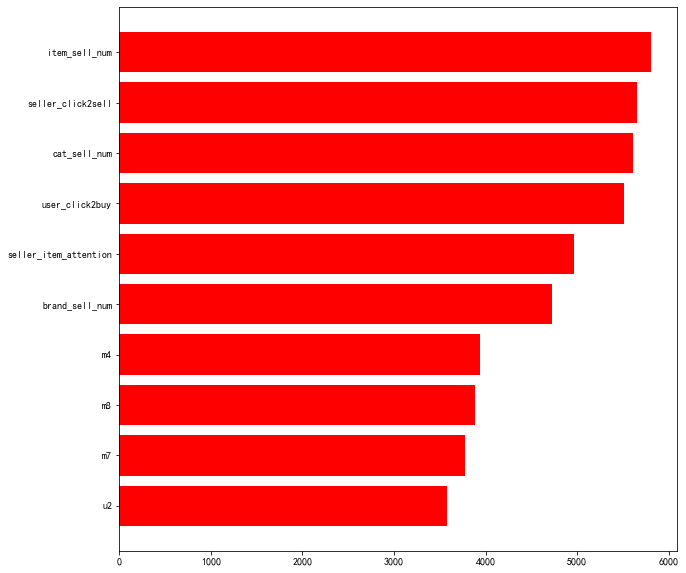

In [42]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
plt.figure(figsize=(10,10))#设置画布的尺寸
print(len(train_X.columns.tolist()))
print(len(model.feature_importances_))

pd_feature_importances=pd.DataFrame()
pd_feature_importances['feature']=train_X.columns.tolist()
pd_feature_importances['importance']=model.feature_importances_
pd_feature_importances=pd_feature_importances.sort_values(by=['importance'])
plt.barh(pd_feature_importances['feature'][-10:],height=0.8,width=pd_feature_importances['importance'][-10:],align="center",color='r')